# Использование BERT для задачи классификации последовательности




[Исходный туториал](https://curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) + материалы курса Кати Артемовой  на ФКН

**Важные ссылки про BERT**

[Devlin et al 2019](https://arxiv.org/pdf/1810.04805.pdf) - BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding - статья, презентующая BERT

[Vaswani et al 2017](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf) - Attention is all you need - статья, презентующая трансформеры

[Illustrated Transformer](http://jalammar.github.io/illustrated-transformer/) by Jay Allamar - архитектура трансформера в картингах и гифках

[Annotated Transformer](https://nlp.seas.harvard.edu/2018/04/03/attention.html) by harvardnlp -код трансформера на торче, реализующий статью по абзацам

[Transformers](https://huggingface.co/transformers/) by hugging face -  главная open source библиотека, откуда можно брать предобученные бертоподобные модели


Сегодня посмотрим, как можно использовать BERT (или любую другую подобную модель) с помощью библиотеки Transformers.

Общий пайплайн:
BERT используется как начальный блок модели и считает контекстные вектора для слов.
Поверх этого блока мы добавляем "голову" модели, ее архитектура зависит от задачи.
Веса BERT предобучены, но мы проводим дообучение (fine-tuning) на целевой задаче.




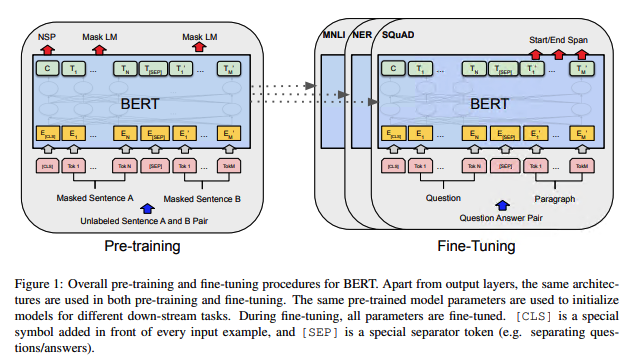

Наша сегодняшняя задача - классификация отзывов.
Данные - отзывы на приложения в Google Play, классы:  negative (1,2), neutral (3), positive (4,5) 

## Загрузка данных

Мы будем использовать библиотеку [Transformers](https://huggingface.co/transformers/) от Hugging Face 

In [ ]:
!pip install -q -U watermark

In [ ]:
!pip install transformers

In [ ]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Загрузим набор данных, который мы будем использовать для обучения и тестирования модели -- отзывы на приложения в Google Play.


In [ ]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

In [ ]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader


In [ ]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

In [ ]:
df = pd.read_csv("reviews.csv")

In [ ]:
df.shape

In [ ]:
df.info()

In [ ]:
from google.colab import data_table
data_table.disable_dataframe_formatter()

In [ ]:
df.head()

Посмотрим на распределение классов в выборке

In [ ]:
sns.countplot(x=df.score)
plt.xlabel('review score');

Можно видеть, что данные несбалансированы. 
Теперь приведем метки классов к другому виду -- разделим их на 3 класса: негативные, нейтральные и позитивные.

In [ ]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [ ]:
class_names = ['negative', 'neutral', 'positive']

In [ ]:
ax = sns.countplot(x=df.sentiment)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names);

В таком виде классы почти сбалансированы.

## Предобработка данных

Для обучение модели BERT нам нужно обработать исходный текст определенным образом:
* Добавить служебные символы для разделения предложений и классификации
* Привести все последовательности к единой длине (используя padding)
* Создать список (*attention mask*) из 0 и 1, в котором 0 будут соответствовать вспомогательным токенам (padding), а 1 $-$ настоящим.



Бертоподобных моделей огромное множество, но если они интегрированы в библиотеку Transformers, сменить одну модель на другую очень просто. Вот [здесь](https://huggingface.co/transformers/pretrained_models.html) можно посмотреть, какие модели есть библиотеке. 

Model id в таблице используются для двух вещей - подгрузки весов в саму модель и подгрузки правильного токенизатора. Вам не нужно самим добавлять спецсимволы и строить индексы словаря, это сделает токенайзер, соотвествующий выбранной модели.
Сегодняшний выбор - модель 'bert-base-cased'

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

Загрузим предобученный [BertTokenizer](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer):

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Посмотрим, как работает модель токенизации для BERT.



In [ ]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

In [ ]:
sample_txt = 'He started a new book, it was quite readable'

tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

##  Специальные токены

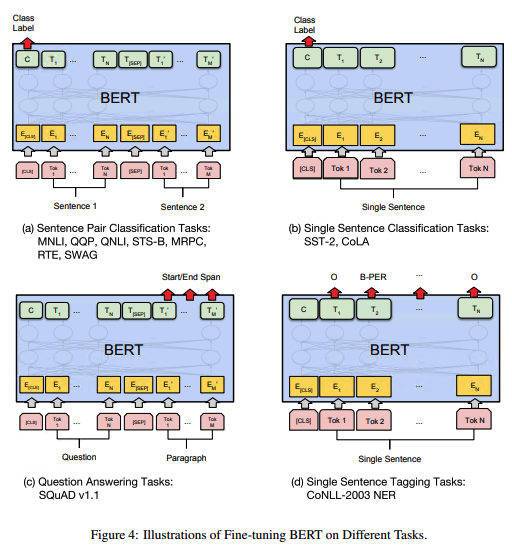



`[SEP]` - метка конца предложения


In [ ]:
tokenizer.sep_token, tokenizer.sep_token_id

`[CLS]` - чтобы использовать модель BERT для классификации, мы должны добавить этот токен в начало каждого предложения

In [ ]:
tokenizer.cls_token, tokenizer.cls_token_id

Также существует специальный вспомогательный токен для выравнивания длин последовательностей

In [ ]:
tokenizer.pad_token, tokenizer.pad_token_id

Вся эта предобработка может быть сделана с помощью метода encode_plus

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

encoding.keys()

In [ ]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

Такая же длина будет и у *attention mask*

In [ ]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])


Установим максимальную длину последовательности равной 160

In [ ]:
MAX_LEN = 160

Теперь создадим датасет PyTorch, который понадобится в дальнейшем для обучения модели

In [ ]:

class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
      truncation=True
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

Разделим данные на обучающую, тестовую и валидационную выборки 

In [ ]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
df_train, df_test = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [ ]:
df_train.shape, df_val.shape, df_test.shape


Создадим итераторы по данным
- train_data_loader - данные для обучения
- val_data_loader - данные для валидации модели при обучении
- test_data_loader - данные для тестирования модели

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [ ]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

Посмотрим на пример одного батча из нашего итератора train_data_loader



In [ ]:
data = next(iter(train_data_loader))

In [ ]:
data.keys()

In [ ]:
print(data['review_text'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

In [ ]:
data['targets']

## Классификация сентимента с использованием модели BERT от Hugging Face


В библиотеке Transformers от Hugging Face есть много моделей для разных задач: [BertForSequenceClassification](https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification), [BertForQuestionAnswering](https://huggingface.co/transformers/model_doc/bert.html#bertforquestionanswering) и другие. Все они являются надстройками над базовой моделью BERT.

В данном случае мы будем использовать базовую модель [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) и реализуем на её основе свой классификатор текстов по тональности.

In [ ]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
bert_model

Попробуем использовать эту модель 

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

In [ ]:
encoding['attention_mask']

In [ ]:
last_hidden_state, pooled_output, hidden_states = bert_model( 
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  output_hidden_states=True,
  return_dict=False)


В переменную last_hidden_state теперь записана последовательность скрытых состояний последнего слоя модели. 

In [ ]:
print(last_hidden_state.shape)
print(pooled_output.shape)
print(len(hidden_states))

In [ ]:
for state in hidden_states:
  print(state.shape)

Посмотрим на BERT эмбеддинги некоторых слов в предложениях.

In [ ]:
text1 = df.loc[16]['content']
text2 = df.loc[338]['content']
print(text1)
print(text2)

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
tokenizer2 = PreTrainedTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
tokenizer2.sep_token = tokenizer.sep_token
tokenizer2.pad_token = tokenizer.pad_token

In [ ]:
encoding = tokenizer.encode_plus(
  text1,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

In [ ]:
encoding2 = tokenizer2.encode_plus(
  text1,
  max_length=50,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True,
  return_offsets_mapping=True
)

In [ ]:
print(encoding.keys())
print(encoding2.keys())

In [ ]:
encoding2['offset_mapping']

In [ ]:
encoding['input_ids']

In [ ]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask'],
  return_dict=False)

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]))

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0]).index('subscription')

In [ ]:
emb1 = last_hidden_state[0, 17]
emb1.shape

In [ ]:
encoding2 = tokenizer.encode_plus(
  text2,
  max_length=30,
  add_special_tokens=True, # Добавить '[CLS]' и '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Вернуть тензор PyTorch
  truncation=True
)

last_hidden_state2, pooled_output2 = bert_model(
  input_ids=encoding2['input_ids'], 
  attention_mask=encoding2['attention_mask'],
  return_dict=False)

In [ ]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding2['input_ids'][0]).index('premium')

In [ ]:
emb2 = last_hidden_state2[0, 1]
emb2.shape

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cosine_similarity( [emb1.detach().cpu().numpy()], [emb2.detach().cpu().numpy()])

Опишем наконец наш классификатор на основе BertModel

In [ ]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [ ]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

In [ ]:
model

Перенесем на GPU один из наших батчей (для примера).

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

Применим модель к данным.

In [ ]:
output = model(input_ids, attention_mask)
output

Если хотим получить вероятности классов, применяем SoftMax к выходу модели.

In [ ]:
F.softmax(output, dim=1)

## Обучение модели

Для дообучения модели будем использовать оптимизатор [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw) из библиотеки Hugging Face. 



Авторы модели BERT рекомендуют использовать следующие параметры для дообучения модели:
- Размер батча: 16, 32
- Learning rate (с оптимайзером Adam): 5e-5, 3e-5, 2e-5
- Количество эпох: 2, 3, 4

In [ ]:

#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False


In [ ]:
list(model.bert.encoder.layer[3].parameters())[0]

In [ ]:
EPOCHS = 2

#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

Реализуем функцию для одной эпохи обучения

In [ ]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

Также реализуем функцию для оценки качества модели на данных из data_loader

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

Используя эти две функции, описанные выше, реализуем процедуру дообучения нашей модели 

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc


При обучении модели мы сохраняем веса наилучшей модели на основе точности на валидационной выборке.

Обучение модели занимает некоторое время. Теперь мы можем сравнить точность на валидационной и на обучающей выборке.

In [ ]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

In [ ]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
'''
model = SentimentClassifier(len(class_names))
model.load_state_dict(torch.load('best_model_state.bin'))
model = model.to(device)
'''

## Оценка результатов работы модели

Подсчитаем точность (accuracy) модели на тестовой выборке.

In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

Accuracy на тестовых данных и на валидационной выборке дают близкие значения. Из этого можно сделать вывод, что получившаяся модель обладает хорошей обобщающей способностью.

Теперь реализуем вспомогательную функцию, которая будет получать предсказания из нашей модели.

In [ ]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

Давайте посмотрим на результаты работы модели на тестовой выборке.

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

Из данного отчета видно, что сложнее всего классифицировать нейтральные отзывы. 

Посмотрим также на confusion matrix предсказаний модели на тестовой выборке.

In [ ]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

Здесь также можно видеть, что модели сложнее всего классифицировать нейтральные отзывы. 

In [ ]:
idx = 2

review_text = y_review_texts[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

In [ ]:
print("\n".join(wrap(review_text)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

## Предсказание на произвольных текстах

Теперь нам осталось научиться использовать нашу модель для предсказания тональности любого текста.

In [ ]:
review_text = "I love completing my todos! Best app ever!!!"

Для использования нашей модели нам следует токенизировать текст соответствующим образом.

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',
  truncation=True
)

Теперь получим предсказания нашей модели.

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
prediction = torch.argmax(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

##Trainer от HuggingFace

Библиотека HuggingFace предоставляет инструменты, которые упрощают обучение и оценку моделей, выложенных в репозиторий библиотеки. Рассмотрим эти инструменты на примере задачи анализа тональности. Будем обучать и оценивать модели на датасете imdb, состоящем из отзывов пользователей о фильмах. 

Оригинал: https://huggingface.co/transformers/custom_datasets.html#sequence-classification-with-imdb-reviews

Для загрузки датасета воспользуемся библиотекой datasets, реализованной HuggingFace. Данная библиотека предоставляет возможность быстро и удобно скачивать различные бенчмарки: https://huggingface.co/datasets

In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset

imdb_dataset = load_dataset('imdb')

In [ ]:
imdb_dataset

In [ ]:
imdb_dataset["train"]["text"][:10]

In [ ]:
imdb_dataset["train"]["label"][:10]

Сократим количество примеров, чтобы процесс обучения был быстрее.

In [ ]:
train_texts = imdb_dataset["train"]["text"][:2000]
train_labels = imdb_dataset["train"]["label"][:2000]
test_texts = imdb_dataset["test"]["text"][:1000]
test_labels = imdb_dataset["test"]["label"][:1000]

In [ ]:
del imdb_dataset

Выделим часть обучающих данных для оценки:

In [ ]:
from sklearn.model_selection import train_test_split
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=.2)

Токенизируем данные

In [ ]:
from transformers import DistilBertTokenizerFast
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [ ]:
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

Создадим класс Dataset, который на каждой итерации будет возвращать токенизированный отзыв и класс:

In [ ]:
class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = IMDbDataset(train_encodings, train_labels)
val_dataset = IMDbDataset(val_encodings, val_labels)
test_dataset = IMDbDataset(test_encodings, test_labels)

Опишем функцию для подсчета метрик, которые хотим увидеть при оценке модели (по умолчанию будет вычисляться только loss):

In [ ]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Зададим параметры обучения с помощью TrainingArguments:

In [ ]:
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

Инициализируем модель и запустим fine-tune ее с помощью модуля Trainer. В данном модуле будет автоматически происходить итерация по эпохам, батчам, рассчет функции потерь и градиентов, ничего этого больше руками прописывать не нужно!

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

In [ ]:
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=val_dataset,            # evaluation dataset
    compute_metrics = compute_metrics    # metrics to evaluate
)

trainer.train()

In [ ]:
trainer.evaluate()

Оценим модель на тестовых данных

In [ ]:
trainer.evaluate(eval_dataset=test_dataset, metric_key_prefix="test")